In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import xgboost as xgb
from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from urllib.request import urlretrieve

EXPLORACIÓN Y TRANSFORMACIONES DE DIAMONDS_TRAIN

In [154]:
diamonds_train = pd.read_csv("data/diamonds_train.csv")
diamonds_train = diamonds_train.drop(["index_id", "city_id", "city_id.1", "index_id.1", "cut_id", "color_id", "color_id.1", "clarity_id", "cut_id.1", "index_id.2", "clarity_id.1"], axis = 1)

In [155]:
diamonds_test = pd.read_csv("data/diamonds_test.csv")

In [156]:
numeric_columns = diamonds_train.select_dtypes(include=['int', 'float']).columns
mean_values = diamonds_train[numeric_columns].mean()
diamonds_train[numeric_columns] = diamonds_train[numeric_columns].replace(0, mean_values)

In [157]:
precio_promedio_color_corte = diamonds_train.groupby(['color', 'cut'])['price'].mean().reset_index()

map_color_cut_to_mean_price = {(row['color'], row['cut']): row['price'] for index, row in precio_promedio_color_corte.iterrows()}

diamonds_train['precio_promedio_color_corte'] = diamonds_train.apply(lambda row: map_color_cut_to_mean_price.get((row['color'], row['cut']), 0), axis=1)
diamonds_test['precio_promedio_color_corte'] = diamonds_test.apply(lambda row: map_color_cut_to_mean_price.get((row['color'], row['cut']), 0), axis=1)

In [158]:
diamonds_train

,price,carat,city,color,cut,depth,table,x,y,z,clarity,precio_promedio_color_corte
0,4268,1.21,Dubai,J,Premium,62.4,58.0,6.83,6.79,4.25,VS2,6376.983740
1,505,0.32,Kimberly,H,Very Good,63.0,57.0,4.35,4.38,2.75,VS2,4541.993464
2,2686,0.71,Las Vegas,G,Fair,65.5,55.0,5.62,5.53,3.65,VS1,4473.021368
3,738,0.41,Kimberly,D,Good,63.8,56.0,4.68,4.72,3.00,SI1,3311.693089
4,4882,1.02,Dubai,G,Ideal,60.5,59.0,6.55,6.51,3.95,SI1,3751.364560
...,...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,Antwerp,G,Ideal,62.7,57.0,7.10,7.04,4.43,VS1,3751.364560
40451,12615,2.02,Madrid,F,Good,57.1,60.0,8.31,8.25,4.73,SI2,3477.504518
40452,5457,1.01,Kimberly,H,Ideal,62.7,56.0,6.37,6.42,4.01,SI1,3873.835802
40453,456,0.33,Kimberly,J,Ideal,61.9,54.3,4.45,4.47,2.76,VS1,4854.274311


In [159]:
diamonds_train['volume'] = diamonds_train['x'] * diamonds_train['y'] * diamonds_train['z']
diamonds_train['relative_weight'] = diamonds_train['carat'] / diamonds_train['volume']
diamonds_train

,price,carat,city,color,cut,depth,table,x,y,z,clarity,precio_promedio_color_corte,volume,relative_weight
0,4268,1.21,Dubai,J,Premium,62.4,58.0,6.83,6.79,4.25,VS2,6376.983740,197.096725,0.006139
1,505,0.32,Kimberly,H,Very Good,63.0,57.0,4.35,4.38,2.75,VS2,4541.993464,52.395750,0.006107
2,2686,0.71,Las Vegas,G,Fair,65.5,55.0,5.62,5.53,3.65,VS1,4473.021368,113.436890,0.006259
3,738,0.41,Kimberly,D,Good,63.8,56.0,4.68,4.72,3.00,SI1,3311.693089,66.268800,0.006187
4,4882,1.02,Dubai,G,Ideal,60.5,59.0,6.55,6.51,3.95,SI1,3751.364560,168.429975,0.006056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,Antwerp,G,Ideal,62.7,57.0,7.10,7.04,4.43,VS1,3751.364560,221.429120,0.006052
40451,12615,2.02,Madrid,F,Good,57.1,60.0,8.31,8.25,4.73,SI2,3477.504518,324.276975,0.006229
40452,5457,1.01,Kimberly,H,Ideal,62.7,56.0,6.37,6.42,4.01,SI1,3873.835802,163.990554,0.006159
40453,456,0.33,Kimberly,J,Ideal,61.9,54.3,4.45,4.47,2.76,VS1,4854.274311,54.900540,0.006011


In [160]:
#Voy a quitar los outliers
columns_outliers = ["carat", "depth", "table", "x", "y", "z"]

for c in columns_outliers:

    Q1 = diamonds_train[c].quantile(0.25)
    Q3 = diamonds_train[c].quantile(0.75)

    IQR = Q3-Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    diamonds_train[c] = diamonds_train[c].clip(lower=limite_inferior, upper=limite_superior)
    

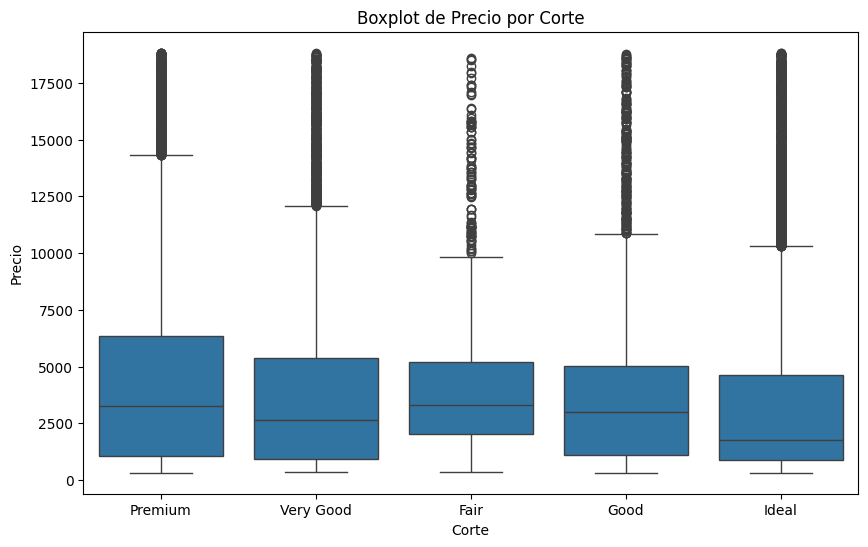

'Curiosamente, el corte de peor calidad (fair) parte siempre\nde un precio más alto.'

In [161]:
#Analizo la relación entre los distintos tipos de corte y el precio

plt.figure(figsize=(10, 6))
sns.boxplot(data=diamonds_train, x='cut', y='price')
plt.title('Boxplot de Precio por Corte')
plt.xlabel('Corte')
plt.ylabel('Precio')
plt.show()

"""Curiosamente, el corte de peor calidad (fair) parte siempre
de un precio más alto."""

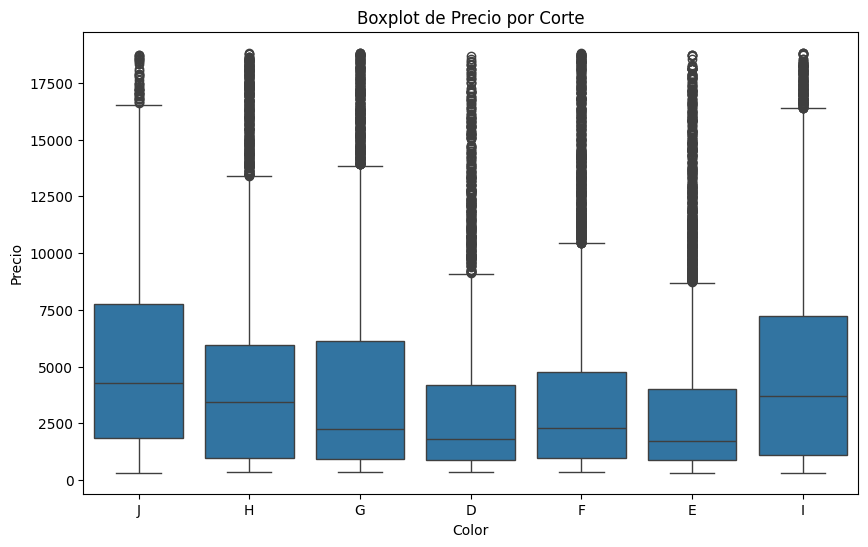

'De nuevo, el peor color (J) es el que parte de un mayor precio \ninicial. Tal vez haya que modificar las labels del encoding. El D, \nque en teoría es el mejor color, tiene un rango de precio mucho más\npequeño'

In [162]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=diamonds_train, x='color', y='price')
plt.title('Boxplot de Precio por Corte')
plt.xlabel('Color')
plt.ylabel('Precio')
plt.show()

"""De nuevo, el peor color (J) es el que parte de un mayor precio 
inicial. Tal vez haya que modificar las labels del encoding. El D, 
que en teoría es el mejor color, tiene un rango de precio mucho más
pequeño"""

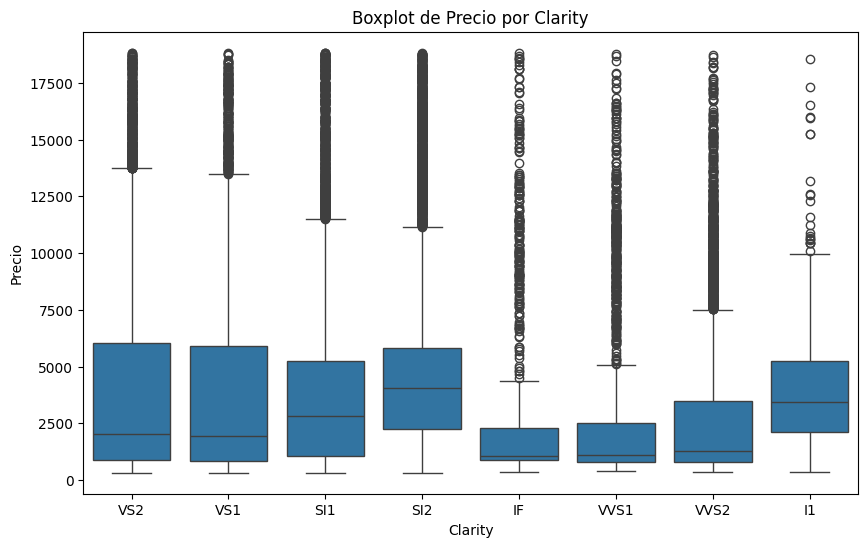

'De nuevo, los dos peores (I1, SI1) tienen precios más elevados.'

In [163]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=diamonds_train, x='clarity', y='price')
plt.title('Boxplot de Precio por Clarity')
plt.xlabel('Clarity')
plt.ylabel('Precio')
plt.show()
"""De nuevo, los dos peores (I1, SI1) tienen precios más elevados."""

In [164]:
"""Voy a ver cuáles tienen mayor relación con un precio elevado
dentro de cada categoría para modificar el label encoding y que
tenga sentido."""

'Voy a ver cuáles tienen mayor relación con un precio elevado\ndentro de cada categoría para modificar el label encoding y que\ntenga sentido.'

In [165]:
mean_prices_by_cut = diamonds_train.groupby('cut')['price'].mean().sort_values(ascending=False)
mean_prices_by_cut

cut
Premium      4617.322612
Fair         4333.271980
Very Good    3994.444420
Good         3880.611794
Ideal        3436.112577
Name: price, dtype: float64

In [166]:
median_prices_by_cut = diamonds_train.groupby('cut')['price'].median().sort_values(ascending=False)
median_prices_by_cut

cut
Fair         3302.0
Premium      3242.5
Good         2990.0
Very Good    2644.0
Ideal        1787.0
Name: price, dtype: float64

In [167]:
median_prices_by_color = diamonds_train.groupby('color')['price'].median().sort_values(ascending=False)
median_prices_by_color

color
J    4268.5
I    3709.5
H    3447.0
F    2312.0
G    2262.0
D    1820.0
E    1735.0
Name: price, dtype: float64

In [168]:
median_prices_by_clarity = diamonds_train.groupby('clarity')['price'].median().sort_values(ascending=False)
median_prices_by_clarity

clarity
SI2     4072.0
I1      3439.0
SI1     2822.0
VS2     2036.5
VS1     1957.0
VVS2    1289.0
VVS1    1097.0
IF      1080.0
Name: price, dtype: float64

In [169]:
mean_prices_by_clarity = diamonds_train.groupby('clarity')['price'].mean().sort_values(ascending=False)
mean_prices_by_clarity

clarity
SI2     5101.044307
SI1     3999.856908
I1      3971.206039
VS2     3913.590182
VS1     3796.813551
VVS2    3240.978942
IF      2797.897513
VVS1    2559.498558
Name: price, dtype: float64

In [170]:
diamonds_train["cut_encoded"] = 0 

for i, r in diamonds_train.iterrows():
    if r["cut"] == "Fair":
        diamonds_train.at[i, "cut_encoded"] = 1.0
    elif r["cut"] == "Good":
        diamonds_train.at[i, "cut_encoded"] = 0.7937
    elif r["cut"] == "Very Good":
        diamonds_train.at[i, "cut_encoded"] = 0.565
    elif r["cut"] == "Premium":
        diamonds_train.at[i, "cut_encoded"] = 0.9604
    elif r["cut"] == "Ideal":
        diamonds_train.at[i, "cut_encoded"] = 0
diamonds_train

,price,carat,city,color,cut,depth,table,x,y,z,clarity,precio_promedio_color_corte,volume,relative_weight,cut_encoded
0,4268,1.21,Dubai,J,Premium,62.40,58.0,6.83,6.79,4.25,VS2,6376.983740,197.096725,0.006139,0.9604
1,505,0.32,Kimberly,H,Very Good,63.00,57.0,4.35,4.38,2.75,VS2,4541.993464,52.395750,0.006107,0.5650
2,2686,0.71,Las Vegas,G,Fair,64.75,55.0,5.62,5.53,3.65,VS1,4473.021368,113.436890,0.006259,1.0000
3,738,0.41,Kimberly,D,Good,63.80,56.0,4.68,4.72,3.00,SI1,3311.693089,66.268800,0.006187,0.7937
4,4882,1.02,Dubai,G,Ideal,60.50,59.0,6.55,6.51,3.95,SI1,3751.364560,168.429975,0.006056,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,Antwerp,G,Ideal,62.70,57.0,7.10,7.04,4.43,VS1,3751.364560,221.429120,0.006052,0.0000
40451,12615,2.00,Madrid,F,Good,58.75,60.0,8.31,8.25,4.73,SI2,3477.504518,324.276975,0.006229,0.7937
40452,5457,1.01,Kimberly,H,Ideal,62.70,56.0,6.37,6.42,4.01,SI1,3873.835802,163.990554,0.006159,0.0000
40453,456,0.33,Kimberly,J,Ideal,61.90,54.3,4.45,4.47,2.76,VS1,4854.274311,54.900540,0.006011,0.0000


In [171]:
diamonds_train["clarity_encoded"] = 0 

for i, r in diamonds_train.iterrows():
    if r["clarity"] == "I1":
        diamonds_train.at[i, "clarity_encoded"] = 0.7888
    elif r["clarity"] == "SI2":
        diamonds_train.at[i, "clarity_encoded"] = 1.0
    elif r["clarity"] == "SI1":
        diamonds_train.at[i, "clarity_encoded"] = 0.5826
    elif r["clarity"] == "VS2":
        diamonds_train.at[i, "clarity_encoded"] = 0.3198
    elif r["clarity"] == "VS1":
        diamonds_train.at[i, "clarity_encoded"] = 0.2933
    elif r["clarity"] == "VVS2":
        diamonds_train.at[i, "clarity_encoded"] = 0.0698
    elif r["clarity"] == "VVS1":
        diamonds_train.at[i, "clarity_encoded"] = 0.0057
    elif r["clarity"] == "IF":
        diamonds_train.at[i, "clarity_encoded"] = 0
diamonds_train

,price,carat,city,color,cut,depth,table,x,y,z,clarity,precio_promedio_color_corte,volume,relative_weight,cut_encoded,clarity_encoded
0,4268,1.21,Dubai,J,Premium,62.40,58.0,6.83,6.79,4.25,VS2,6376.983740,197.096725,0.006139,0.9604,0.3198
1,505,0.32,Kimberly,H,Very Good,63.00,57.0,4.35,4.38,2.75,VS2,4541.993464,52.395750,0.006107,0.5650,0.3198
2,2686,0.71,Las Vegas,G,Fair,64.75,55.0,5.62,5.53,3.65,VS1,4473.021368,113.436890,0.006259,1.0000,0.2933
3,738,0.41,Kimberly,D,Good,63.80,56.0,4.68,4.72,3.00,SI1,3311.693089,66.268800,0.006187,0.7937,0.5826
4,4882,1.02,Dubai,G,Ideal,60.50,59.0,6.55,6.51,3.95,SI1,3751.364560,168.429975,0.006056,0.0000,0.5826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,Antwerp,G,Ideal,62.70,57.0,7.10,7.04,4.43,VS1,3751.364560,221.429120,0.006052,0.0000,0.2933
40451,12615,2.00,Madrid,F,Good,58.75,60.0,8.31,8.25,4.73,SI2,3477.504518,324.276975,0.006229,0.7937,1.0000
40452,5457,1.01,Kimberly,H,Ideal,62.70,56.0,6.37,6.42,4.01,SI1,3873.835802,163.990554,0.006159,0.0000,0.5826
40453,456,0.33,Kimberly,J,Ideal,61.90,54.3,4.45,4.47,2.76,VS1,4854.274311,54.900540,0.006011,0.0000,0.2933


In [172]:
diamonds_train["color_encoded"] = 0 

for i, r in diamonds_train.iterrows():
    if r["color"] == "J":
        diamonds_train.at[i, "color_encoded"] = 1
    elif r["color"] == "I":
        diamonds_train.at[i, "color_encoded"] = 0.7784
    elif r["color"] == "H":
        diamonds_train.at[i, "color_encoded"] = 0.6759
    elif r["color"] == "G":
        diamonds_train.at[i, "color_encoded"] = 0.2078
    elif r["color"] == "F":
        diamonds_train.at[i, "color_encoded"] =  0.2277
    elif r["color"] == "E":
        diamonds_train.at[i, "color_encoded"] = 0
    elif r["color"] == "D":
        diamonds_train.at[i, "color_encoded"] = 0.0335
diamonds_train

,price,carat,city,color,cut,depth,table,x,y,z,clarity,precio_promedio_color_corte,volume,relative_weight,cut_encoded,clarity_encoded,color_encoded
0,4268,1.21,Dubai,J,Premium,62.40,58.0,6.83,6.79,4.25,VS2,6376.983740,197.096725,0.006139,0.9604,0.3198,1.0000
1,505,0.32,Kimberly,H,Very Good,63.00,57.0,4.35,4.38,2.75,VS2,4541.993464,52.395750,0.006107,0.5650,0.3198,0.6759
2,2686,0.71,Las Vegas,G,Fair,64.75,55.0,5.62,5.53,3.65,VS1,4473.021368,113.436890,0.006259,1.0000,0.2933,0.2078
3,738,0.41,Kimberly,D,Good,63.80,56.0,4.68,4.72,3.00,SI1,3311.693089,66.268800,0.006187,0.7937,0.5826,0.0335
4,4882,1.02,Dubai,G,Ideal,60.50,59.0,6.55,6.51,3.95,SI1,3751.364560,168.429975,0.006056,0.0000,0.5826,0.2078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,Antwerp,G,Ideal,62.70,57.0,7.10,7.04,4.43,VS1,3751.364560,221.429120,0.006052,0.0000,0.2933,0.2078
40451,12615,2.00,Madrid,F,Good,58.75,60.0,8.31,8.25,4.73,SI2,3477.504518,324.276975,0.006229,0.7937,1.0000,0.2277
40452,5457,1.01,Kimberly,H,Ideal,62.70,56.0,6.37,6.42,4.01,SI1,3873.835802,163.990554,0.006159,0.0000,0.5826,0.6759
40453,456,0.33,Kimberly,J,Ideal,61.90,54.3,4.45,4.47,2.76,VS1,4854.274311,54.900540,0.006011,0.0000,0.2933,1.0000


In [173]:
diamonds_train = diamonds_train.drop(["city", "color", "cut","clarity"], axis=1)

EXPLORACIÓN Y TRANSFORMACIONES DE DIAMONDS_TEST

In [174]:
numeric_columns = diamonds_test.select_dtypes(include=['int', 'float']).columns

mean_values = diamonds_test[numeric_columns].mean()

diamonds_test[numeric_columns] = diamonds_test[numeric_columns].replace(0, mean_values)

In [175]:
diamonds_test['volume'] = diamonds_test['x'] * diamonds_test['y'] * diamonds_test['z']
diamonds_test['relative_weight'] = diamonds_test['carat'] / diamonds_test['volume']

In [176]:
for c in columns_outliers:

    Q1 = diamonds_test[c].quantile(0.25)
    Q3 = diamonds_test[c].quantile(0.75)

    IQR = Q3-Q1

    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    diamonds_test[c] = diamonds_test[c].clip(lower=limite_inferior, upper=limite_superior)


In [177]:
diamonds_test["cut_encoded"] = 0 

for i, r in diamonds_test.iterrows():
    if r["cut"] == "Fair":
        diamonds_test.at[i, "cut_encoded"] = 1.0
    elif r["cut"] == "Good":
        diamonds_test.at[i, "cut_encoded"] = 0.7937
    elif r["cut"] == "Very Good":
        diamonds_test.at[i, "cut_encoded"] = 0.565
    elif r["cut"] == "Premium":
        diamonds_test.at[i, "cut_encoded"] = 0.9604
    elif r["cut"] == "Ideal":
        diamonds_test.at[i, "cut_encoded"] = 0
diamonds_test

,id,carat,cut,color,clarity,depth,table,x,y,z,city,precio_promedio_color_corte,volume,relative_weight,cut_encoded
0,6742,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,Amsterdam,3790.583636,125.806866,0.006279,0.5650
1,1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,Surat,4854.274311,196.129362,0.006118,0.0000
2,2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,Kimberly,5241.424619,246.878712,0.006359,0.9604
3,3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,Kimberly,3790.583636,145.593630,0.006182,0.5650
4,4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,Amsterdam,3790.583636,81.997355,0.006098,0.5650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13480,13480,0.57,Ideal,E,SI1,61.9,56.0,5.35,5.32,3.30,Amsterdam,2624.818649,93.924600,0.006069,0.0000
13481,13481,0.71,Ideal,I,VS2,62.2,55.0,5.71,5.73,3.56,New York City,4409.012354,116.477148,0.006096,0.0000
13482,13482,0.70,Ideal,F,VS1,61.6,55.0,5.75,5.71,3.53,Tel Aviv,3284.470003,115.898725,0.006040,0.0000
13483,13483,0.70,Very Good,F,SI2,58.8,57.0,5.85,5.89,3.45,Surat,3790.583636,118.874925,0.005889,0.5650


In [178]:
diamonds_test["clarity_encoded"] = 0 

for i, r in diamonds_test.iterrows():
    if r["clarity"] == "I1":
        diamonds_test.at[i, "clarity_encoded"] = 0.7888
    elif r["clarity"] == "SI2":
        diamonds_test.at[i, "clarity_encoded"] = 1.0
    elif r["clarity"] == "SI1":
        diamonds_test.at[i, "clarity_encoded"] = 0.5826
    elif r["clarity"] == "VS2":
        diamonds_test.at[i, "clarity_encoded"] = 0.3198
    elif r["clarity"] == "VS1":
        diamonds_test.at[i, "clarity_encoded"] = 0.2933
    elif r["clarity"] == "VVS2":
        diamonds_test.at[i, "clarity_encoded"] = 0.0698
    elif r["clarity"] == "VVS1":
        diamonds_test.at[i, "clarity_encoded"] = 0.0057
    elif r["clarity"] == "IF":
        diamonds_test.at[i, "clarity_encoded"] = 0
diamonds_test

,id,carat,cut,color,clarity,depth,table,x,y,z,city,precio_promedio_color_corte,volume,relative_weight,cut_encoded,clarity_encoded
0,6742,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,Amsterdam,3790.583636,125.806866,0.006279,0.5650,0.5826
1,1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,Surat,4854.274311,196.129362,0.006118,0.0000,0.2933
2,2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,Kimberly,5241.424619,246.878712,0.006359,0.9604,0.5826
3,3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,Kimberly,3790.583636,145.593630,0.006182,0.5650,0.5826
4,4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,Amsterdam,3790.583636,81.997355,0.006098,0.5650,0.2933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13480,13480,0.57,Ideal,E,SI1,61.9,56.0,5.35,5.32,3.30,Amsterdam,2624.818649,93.924600,0.006069,0.0000,0.5826
13481,13481,0.71,Ideal,I,VS2,62.2,55.0,5.71,5.73,3.56,New York City,4409.012354,116.477148,0.006096,0.0000,0.3198
13482,13482,0.70,Ideal,F,VS1,61.6,55.0,5.75,5.71,3.53,Tel Aviv,3284.470003,115.898725,0.006040,0.0000,0.2933
13483,13483,0.70,Very Good,F,SI2,58.8,57.0,5.85,5.89,3.45,Surat,3790.583636,118.874925,0.005889,0.5650,1.0000


In [179]:
diamonds_test["color_encoded"] = 0 

for i, r in diamonds_test.iterrows():
    if r["color"] == "J":
        diamonds_test.at[i, "color_encoded"] = 1.0
    elif r["color"] == "I":
        diamonds_test.at[i, "color_encoded"] = 0.7784
    elif r["color"] == "H":
        diamonds_test.at[i, "color_encoded"] = 0.6759
    elif r["color"] == "G":
        diamonds_test.at[i, "color_encoded"] = 0.2078
    elif r["color"] == "F":
        diamonds_test.at[i, "color_encoded"] = 0.2277
    elif r["color"] == "E":
        diamonds_test.at[i, "color_encoded"] = 0
    elif r["color"] == "D":
        diamonds_test.at[i, "color_encoded"] = 0.0335
diamonds_test

,id,carat,cut,color,clarity,depth,table,x,y,z,city,precio_promedio_color_corte,volume,relative_weight,cut_encoded,clarity_encoded,color_encoded
0,6742,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67,Amsterdam,3790.583636,125.806866,0.006279,0.5650,0.5826,0.2277
1,1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18,Surat,4854.274311,196.129362,0.006118,0.0000,0.2933,1.0000
2,2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57,Kimberly,5241.424619,246.878712,0.006359,0.9604,0.5826,0.6759
3,3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90,Kimberly,3790.583636,145.593630,0.006182,0.5650,0.5826,0.2277
4,4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19,Amsterdam,3790.583636,81.997355,0.006098,0.5650,0.2933,0.2277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13480,13480,0.57,Ideal,E,SI1,61.9,56.0,5.35,5.32,3.30,Amsterdam,2624.818649,93.924600,0.006069,0.0000,0.5826,0.0000
13481,13481,0.71,Ideal,I,VS2,62.2,55.0,5.71,5.73,3.56,New York City,4409.012354,116.477148,0.006096,0.0000,0.3198,0.7784
13482,13482,0.70,Ideal,F,VS1,61.6,55.0,5.75,5.71,3.53,Tel Aviv,3284.470003,115.898725,0.006040,0.0000,0.2933,0.2277
13483,13483,0.70,Very Good,F,SI2,58.8,57.0,5.85,5.89,3.45,Surat,3790.583636,118.874925,0.005889,0.5650,1.0000,0.2277


In [180]:
diamonds_test = diamonds_test.drop(["city", "color", "cut","clarity", "id"], axis=1)

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import pickle
import joblib

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV


In [182]:
diamonds_train

,price,carat,depth,table,x,y,z,precio_promedio_color_corte,volume,relative_weight,cut_encoded,clarity_encoded,color_encoded
0,4268,1.21,62.40,58.0,6.83,6.79,4.25,6376.983740,197.096725,0.006139,0.9604,0.3198,1.0000
1,505,0.32,63.00,57.0,4.35,4.38,2.75,4541.993464,52.395750,0.006107,0.5650,0.3198,0.6759
2,2686,0.71,64.75,55.0,5.62,5.53,3.65,4473.021368,113.436890,0.006259,1.0000,0.2933,0.2078
3,738,0.41,63.80,56.0,4.68,4.72,3.00,3311.693089,66.268800,0.006187,0.7937,0.5826,0.0335
4,4882,1.02,60.50,59.0,6.55,6.51,3.95,3751.364560,168.429975,0.006056,0.0000,0.5826,0.2078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,10070,1.34,62.70,57.0,7.10,7.04,4.43,3751.364560,221.429120,0.006052,0.0000,0.2933,0.2078
40451,12615,2.00,58.75,60.0,8.31,8.25,4.73,3477.504518,324.276975,0.006229,0.7937,1.0000,0.2277
40452,5457,1.01,62.70,56.0,6.37,6.42,4.01,3873.835802,163.990554,0.006159,0.0000,0.5826,0.6759
40453,456,0.33,61.90,54.3,4.45,4.47,2.76,4854.274311,54.900540,0.006011,0.0000,0.2933,1.0000


In [183]:
diamonds_test

,carat,depth,table,x,y,z,precio_promedio_color_corte,volume,relative_weight,cut_encoded,clarity_encoded,color_encoded
0,0.79,62.7,60.0,5.82,5.89,3.67,3790.583636,125.806866,0.006279,0.5650,0.5826,0.2277
1,1.20,61.0,57.0,6.81,6.89,4.18,4854.274311,196.129362,0.006118,0.0000,0.2933,1.0000
2,1.57,62.2,61.0,7.38,7.32,4.57,5241.424619,246.878712,0.006359,0.9604,0.5826,0.6759
3,0.90,63.8,54.0,6.09,6.13,3.90,3790.583636,145.593630,0.006182,0.5650,0.5826,0.2277
4,0.50,62.9,58.0,5.05,5.09,3.19,3790.583636,81.997355,0.006098,0.5650,0.2933,0.2277
...,...,...,...,...,...,...,...,...,...,...,...,...
13480,0.57,61.9,56.0,5.35,5.32,3.30,2624.818649,93.924600,0.006069,0.0000,0.5826,0.0000
13481,0.71,62.2,55.0,5.71,5.73,3.56,4409.012354,116.477148,0.006096,0.0000,0.3198,0.7784
13482,0.70,61.6,55.0,5.75,5.71,3.53,3284.470003,115.898725,0.006040,0.0000,0.2933,0.2277
13483,0.70,58.8,57.0,5.85,5.89,3.45,3790.583636,118.874925,0.005889,0.5650,1.0000,0.2277


In [184]:
X = diamonds_train.drop(columns=['price'])
y = diamonds_train["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
regressor = lgb.LGBMRegressor(boosting_type='gbdt')

param_grid = {
    'learning_rate': [0.1],
    'feature_fraction': [1],
    'bagging_fraction': [0.8],
    'n_estimators': [203],
    'num_leaves': [30],
    'max_depth': [21],
    #'bagging_freq': [0,1],
    'min_data_in_leaf': [8]
}

random_search = RandomizedSearchCV(regressor, 
                                   param_distributions=param_grid,  
                                   cv=4, 
                                   verbose=3, 
                                   scoring='neg_root_mean_squared_error', 
                                   n_jobs=-1)

random_search.fit(X_train, y_train)
y_pred = random_search.best_estimator_.predict(X_test)

best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best parameters found: ", best_params)
print("Best score found: ", best_score)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[

In [186]:
best_model = random_search.best_estimator_
best_model

LGBMRegressor(bagging_fraction=0.8, feature_fraction=1, max_depth=21,
              min_data_in_leaf=8, n_estimators=203, num_leaves=30)

In [187]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

543.7326608054359

In [188]:
y_prediction = best_model.predict(diamonds_test)

[LightGBM] [Warning] feature_fraction is set=1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


In [189]:
solution = []
for i, value in enumerate(y_prediction):
    solution.append((i,value))

In [190]:
submission_file = pd.DataFrame(solution)

In [191]:
submission_file

,0,1
0,0,2879.559939
1,1,5506.406630
2,2,10478.910081
3,3,4042.077560
4,4,1560.207888
...,...,...
13480,13480,1711.757191
13481,13481,2362.679645
13482,13482,3185.371363
13483,13483,2114.410565


In [192]:
submission_file.columns = ["id", "price"]

In [193]:
submission_file.reset_index(drop=True)

,id,price
0,0,2879.559939
1,1,5506.406630
2,2,10478.910081
3,3,4042.077560
4,4,1560.207888
...,...,...
13480,13480,1711.757191
13481,13481,2362.679645
13482,13482,3185.371363
13483,13483,2114.410565


In [194]:
submission_file.to_csv("017.csv", index = False)